In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
cd /content/gdrive/'My Drive'/Diploma

/content/gdrive/My Drive/Diploma


In [3]:
!pip install segmentation-models-pytorch
from zipfile import ZipFile
import useful
import numpy as np
import torch
import segmentation_models_pytorch as smp
import torch.nn as nn
import torch.nn.functional as F
import math
from torch.utils.data import Dataset, DataLoader
from data import DepthDataset, RandomHorizontalFlip, ToTensorTest, ToTensorTrain, RandomRotate
from torchvision import transforms
from PIL import ImageFilter
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image

     |████████████████████████████████| 71kB 7.5MB/s 
     |████████████████████████████████| 245kB 17.7MB/s 
     |████████████████████████████████| 61kB 10.2MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp37-none-any.whl size=12420 sha256=9357bb659c99d2b16d8c91b37acb0eaac92dac0941cf6d420ad9c1da2440cdbb
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp37-none-any.whl size=60963 sha256=0954e179c1080c878cb82c3b9ad2db27c8de74859fb8941dcc64d372392a9e3b
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built efficientnet-pytorch pretrainedmodels


In [ ]:
data, nyu2_train, nyu2_test  = useful.load_zip('nyu_data.zip')

Loading dataset zip file...Loaded (50688).


In [ ]:
transformed_training = DepthDataset(data, nyu2_train, transform=None)

In [ ]:
transformed_testing = DepthDataset(data, nyu2_test, transform=None)

#**Tensors**

###**Image to tensor**

In [ ]:
torch.from_numpy(np.array(transformed_training[0]['image']).transpose((2, 0, 1))).div(255)

tensor([[[1.0000, 0.9451, 1.0000,  ..., 1.0000, 1.0000, 0.9922],
         [1.0000, 0.9882, 1.0000,  ..., 0.9961, 1.0000, 1.0000],
         [0.9804, 0.9961, 1.0000,  ..., 1.0000, 1.0000, 0.9804],
         ...,
         [0.9961, 1.0000, 1.0000,  ..., 0.9882, 0.9843, 0.9882],
         [1.0000, 1.0000, 1.0000,  ..., 0.9843, 0.9882, 0.9725],
         [1.0000, 1.0000, 1.0000,  ..., 0.9686, 0.9882, 0.9725]],

        [[0.9961, 0.9412, 0.9961,  ..., 0.9843, 0.9843, 0.9686],
         [0.9961, 0.9843, 0.9961,  ..., 0.9882, 0.9922, 0.9882],
         [0.9765, 0.9922, 0.9961,  ..., 0.9961, 0.9961, 0.9686],
         ...,
         [0.9804, 0.9922, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
         [0.9882, 0.9922, 0.9961,  ..., 1.0000, 1.0000, 0.9922],
         [0.9961, 0.9961, 0.9882,  ..., 0.9882, 1.0000, 0.9922]],

        [[1.0000, 0.9608, 1.0000,  ..., 0.9882, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 0.9922, 1.0000, 1.0000],
         [0.9961, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.

In [ ]:
torch.from_numpy(np.array(transformed_testing[0]['image']).transpose((2, 0, 1)))/255*1000

tensor([[[1000., 1000., 1000.,  ..., 1000., 1000., 1000.],
         [1000., 1000., 1000.,  ..., 1000., 1000., 1000.],
         [1000., 1000., 1000.,  ..., 1000., 1000., 1000.],
         ...,
         [1000., 1000., 1000.,  ..., 1000., 1000., 1000.],
         [1000., 1000., 1000.,  ..., 1000., 1000., 1000.],
         [1000., 1000., 1000.,  ..., 1000., 1000., 1000.]],

        [[1000., 1000., 1000.,  ..., 1000., 1000., 1000.],
         [1000., 1000., 1000.,  ..., 1000., 1000., 1000.],
         [1000., 1000., 1000.,  ..., 1000., 1000., 1000.],
         ...,
         [1000., 1000., 1000.,  ..., 1000., 1000., 1000.],
         [1000., 1000., 1000.,  ..., 1000., 1000., 1000.],
         [1000., 1000., 1000.,  ..., 1000., 1000., 1000.]],

        [[1000., 1000., 1000.,  ..., 1000., 1000., 1000.],
         [1000., 1000., 1000.,  ..., 1000., 1000., 1000.],
         [1000., 1000., 1000.,  ..., 1000., 1000., 1000.],
         ...,
         [1000., 1000., 1000.,  ..., 1000., 1000., 1000.],
         [

###**Depth to tensor(cm)**

FOR TRAINING

In [ ]:
np.array(transformed_training[6]['depth'])

array([[77, 77, 77, ..., 46, 46, 46],
       [77, 77, 77, ..., 46, 46, 46],
       [77, 77, 77, ..., 46, 46, 46],
       ...,
       [48, 48, 48, ..., 36, 36, 36],
       [48, 48, 48, ..., 36, 36, 36],
       [48, 48, 48, ..., 36, 36, 36]], dtype=uint8)

In [ ]:
depth = np.expand_dims(np.array(transformed_training[6]['depth']), axis=-1)
depth = depth.transpose((2, 0, 1))
depth = torch.from_numpy(depth).float()/255*1000
torch.clamp(depth,10,1000)

tensor([[[301.9608, 301.9608, 301.9608,  ..., 180.3922, 180.3922, 180.3922],
         [301.9608, 301.9608, 301.9608,  ..., 180.3922, 180.3922, 180.3922],
         [301.9608, 301.9608, 301.9608,  ..., 180.3922, 180.3922, 180.3922],
         ...,
         [188.2353, 188.2353, 188.2353,  ..., 141.1765, 141.1765, 141.1765],
         [188.2353, 188.2353, 188.2353,  ..., 141.1765, 141.1765, 141.1765],
         [188.2353, 188.2353, 188.2353,  ..., 141.1765, 141.1765, 141.1765]]])

In [ ]:
depth = np.expand_dims(np.array(transformed_testing[6]['depth']), axis=-1)
depth = depth.transpose((2, 0, 1))
depth = torch.from_numpy(depth).float()/10 #/10000 * 1000
torch.clamp(depth,10,1000)

tensor([[[253.9000, 253.9000, 253.9000,  ..., 179.8000, 179.8000, 179.8000],
         [253.9000, 253.9000, 253.9000,  ..., 179.8000, 179.8000, 179.8000],
         [253.9000, 253.9000, 253.9000,  ..., 179.8000, 179.8000, 179.8000],
         ...,
         [155.3000, 155.4000, 155.4000,  ..., 174.9000, 174.9000, 174.8000],
         [155.4000, 155.4000, 155.4000,  ..., 174.9000, 174.9000, 174.9000],
         [155.4000, 155.4000, 155.5000,  ..., 174.9000, 174.9000, 174.9000]]])

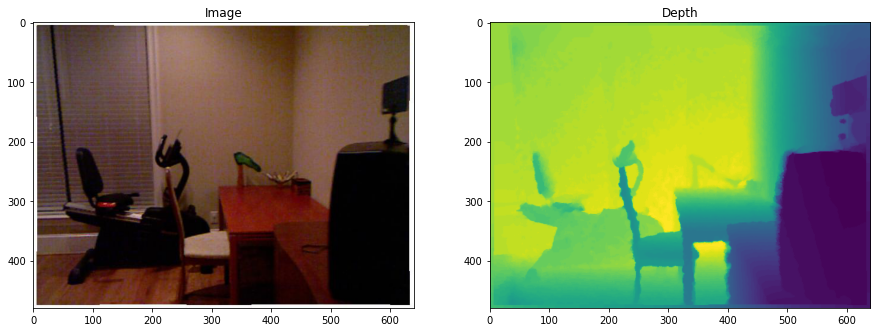

In [ ]:
useful.plot_image_depth(transformed_training[7]['image'],transformed_training[7]['depth'])

FOR TESTING

In [ ]:
depth = np.expand_dims(np.array(transformed_training[0]['depth']), axis=-1)
depth = depth.transpose((2, 0, 1))
depth = torch.from_numpy(depth).float()
torch.clamp(depth,10,1000)

tensor([[[30., 30., 30.,  ..., 24., 24., 24.],
         [30., 30., 30.,  ..., 24., 24., 24.],
         [30., 30., 30.,  ..., 24., 24., 24.],
         ...,
         [21., 21., 21.,  ..., 27., 27., 27.],
         [21., 21., 21.,  ..., 27., 27., 27.],
         [21., 21., 21.,  ..., 27., 27., 27.]]])

In [ ]:
depth = np.expand_dims(np.array(transformed_testing[0]['depth']), axis=-1)
depth = depth.transpose((2, 0, 1))
depth = torch.from_numpy(depth).float()
torch.clamp(depth,10,1000)

tensor([[[1000., 1000., 1000.,  ..., 1000., 1000., 1000.],
         [1000., 1000., 1000.,  ..., 1000., 1000., 1000.],
         [1000., 1000., 1000.,  ..., 1000., 1000., 1000.],
         ...,
         [1000., 1000., 1000.,  ..., 1000., 1000., 1000.],
         [1000., 1000., 1000.,  ..., 1000., 1000., 1000.],
         [1000., 1000., 1000.,  ..., 1000., 1000., 1000.]]])

In [ ]:
np.array(transformed_testing[0]['depth'])

array([[2752, 2752, 2752, ..., 2242, 2242, 2242],
       [2751, 2752, 2752, ..., 2242, 2242, 2242],
       [2751, 2751, 2752, ..., 2242, 2242, 2242],
       ...,
       [2198, 2198, 2197, ..., 2081, 2081, 2080],
       [2197, 2197, 2197, ..., 2081, 2081, 2081],
       [2197, 2197, 2197, ..., 2081, 2081, 2081]], dtype=int32)

In [ ]:
def _is_pil_image(img):
    return isinstance(img, Image.Image)


def _is_numpy_image(img):
    return isinstance(img, np.ndarray) and (img.ndim in {2, 3})

In [ ]:
def to_tensor(pic):
        if not (_is_pil_image(pic) or _is_numpy_image(pic)):
            raise TypeError(
                'pic should be PIL Image or ndarray. Got {}'.format(type(pic)))

        if isinstance(pic, np.ndarray):
            img = torch.from_numpy(pic.transpose((2, 0, 1)))
            return img.float().div(255)

        # handle PIL Image
        if pic.mode == 'I':
            img = torch.from_numpy(np.array(pic, np.int32))
        elif pic.mode == 'I;16':
            img = torch.from_numpy(np.array(pic, np.int16))
        else:
            img = torch.ByteTensor(
                torch.ByteStorage.from_buffer(pic.tobytes()))
        # PIL image mode: 1, L, P, I, F, RGB, YCbCr, RGBA, CMYK
        if pic.mode == 'YCbCr':
            nchannel = 3
        elif pic.mode == 'I;16':
            nchannel = 1
        else:
            nchannel = len(pic.mode)
        img = img.view(pic.size[1], pic.size[0], nchannel)
        # put it from HWC to CHW format
        # yikes, this transpose takes 80% of the loading time/CPU
        img = img.transpose(0, 1).transpose(0, 2).contiguous()
        if isinstance(img, torch.ByteTensor):
            return img.float().div(255)
        else:
            return img

In [ ]:
to_tensor(transformed_training[0]['depth'])

tensor([[[0.1176, 0.1176, 0.1176,  ..., 0.0941, 0.0941, 0.0941],
         [0.1176, 0.1176, 0.1176,  ..., 0.0941, 0.0941, 0.0941],
         [0.1176, 0.1176, 0.1176,  ..., 0.0941, 0.0941, 0.0941],
         ...,
         [0.0824, 0.0824, 0.0824,  ..., 0.1059, 0.1059, 0.1059],
         [0.0824, 0.0824, 0.0824,  ..., 0.1059, 0.1059, 0.1059],
         [0.0824, 0.0824, 0.0824,  ..., 0.1059, 0.1059, 0.1059]]])

In [ ]:
np.array(transformed_training[0]['depth'])

array([[30, 30, 30, ..., 24, 24, 24],
       [30, 30, 30, ..., 24, 24, 24],
       [30, 30, 30, ..., 24, 24, 24],
       ...,
       [21, 21, 21, ..., 27, 27, 27],
       [21, 21, 21, ..., 27, 27, 27],
       [21, 21, 21, ..., 27, 27, 27]], dtype=uint8)

In [ ]:
depth = np.expand_dims(np.array(transformed_testing[0]['depth']), axis=-1)
depth = depth.transpose((2, 0, 1))
depth = torch.from_numpy(depth).float()/1000
depth

tensor([[[2.7520, 2.7520, 2.7520,  ..., 2.2420, 2.2420, 2.2420],
         [2.7510, 2.7520, 2.7520,  ..., 2.2420, 2.2420, 2.2420],
         [2.7510, 2.7510, 2.7520,  ..., 2.2420, 2.2420, 2.2420],
         ...,
         [2.1980, 2.1980, 2.1970,  ..., 2.0810, 2.0810, 2.0800],
         [2.1970, 2.1970, 2.1970,  ..., 2.0810, 2.0810, 2.0810],
         [2.1970, 2.1970, 2.1970,  ..., 2.0810, 2.0810, 2.0810]]])

#**Losses**

In [ ]:
ground_truth = transformed_training[6]['depth']
pseudo_predicted = transformed_training[6]['depth'].filter(ImageFilter.SMOOTH_MORE)

In [ ]:
np.array(transformed_training[6]['depth']).shape

(480, 640)

In [ ]:
noise = np.random.normal(10, 20, size=np.shape(pseudo_predicted))
noise

In [ ]:
pseudo_predicted = pseudo_predicted+noise

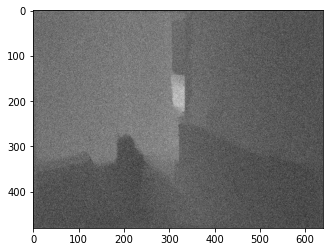

In [ ]:
plt.imshow(pseudo_predicted, cmap='gray')
plt.show()

In [ ]:
true = useful.depth_to_tensor(ground_truth)
pred = useful.depth_to_tensor(pseudo_predicted)

**L1 loss**

In [ ]:
l1_criterion = nn.L1Loss()
loss_depth = l1_criterion(pred, true)
print('Loss L1: {loss_depth:.4f}'.format(loss_depth = loss_depth.item()))

Loss L1: 0.2927


In [ ]:
mse_criterion = nn.MSELoss()
loss_depth = mse_criterion(pred, true)
print('Loss L1: {loss_depth:.4f}'.format(loss_depth = loss_depth.item()))

Loss L1: 5.0994


In [ ]:
mse_criterion = nn.MSELoss()
loss_depth = mse_criterion(pred, true)
print('Loss mse: {loss_depth:.4f}'.format(loss_depth = loss_depth.item()))

In [ ]:
loss_depth = berHuLoss(pred, true)
print('Loss BerHu: {loss_depth:.4f}'.format(loss_depth = loss_depth.item()))

Loss BerHu: 3.9157


In [4]:
def berHuLoss(pred, target):
    huber_c = torch.max(pred - target)
    huber_c = 0.2 * huber_c
    valid_mask = (target > 0).detach()
    diff = target - pred
    diff = diff[valid_mask]
    diff = diff.abs()
    huber_mask = (diff > huber_c).detach()
    diff2 = diff[huber_mask]
    diff2 = diff2 ** 2
    loss = torch.cat((diff, diff2)).mean()
    return loss

def edges_loss(pred, target, alpha=1):
    def gradient(x):
        h_x = x.size()[-2]
        w_x = x.size()[-1]
        left = x
        right = F.pad(x, [0, 1, 0, 0])[:, :, :, 1:]
        top = x
        bottom = F.pad(x, [0, 0, 0, 1])[:, :, 1:, :]
        dx, dy = right - left, bottom - top 
        dx[:, :, :, -1] = 0
        dy[:, :, -1, :] = 0
        return dx, dy
    gen_dx, gen_dy = gradient(pred)
    gt_dx, gt_dy = gradient(target)
    grad_diff_x = torch.abs(gt_dx - gen_dx)
    grad_diff_y = torch.abs(gt_dy - gen_dy)

    return torch.mean(grad_diff_x ** alpha + grad_diff_y ** alpha)


def gaussian(window_size, sigma):
    gauss = torch.Tensor([math.exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel=1):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = _2D_window.expand(channel, 1, window_size, window_size).contiguous()
    return window

def ssim(img1, img2, val_range, window_size=11, window=None, size_average=True, full=False):
    L = val_range

    padd = 0
    (_, channel, height, width) = img1.size()
    if window is None:
        real_size = min(window_size, height, width)
        window = create_window(real_size, channel=channel).to(img1.device)

    mu1 = F.conv2d(img1, window, padding=padd, groups=channel)
    mu2 = F.conv2d(img2, window, padding=padd, groups=channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.conv2d(img1 * img1, window, padding=padd, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=padd, groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1 * img2, window, padding=padd, groups=channel) - mu1_mu2

    C1 = (0.01 * L) ** 2
    C2 = (0.03 * L) ** 2

    v1 = 2.0 * sigma12 + C2
    v2 = sigma1_sq + sigma2_sq + C2
    cs = torch.mean(v1 / v2)  # contrast sensitivity

    ssim_map = ((2 * mu1_mu2 + C1) * v1) / ((mu1_sq + mu2_sq + C1) * v2)

    if size_average:
        ret = ssim_map.mean()
    else:
        ret = ssim_map.mean(1).mean(1).mean(1)

    if full:
        return ret, cs

    return ret

#**Training**

In [5]:
data, nyu2_train, nyu2_test  = useful.load_zip('nyu_data.zip')

Loading dataset zip file...Loaded (50688).


##**Model**

In [ ]:
model = smp.Unet(encoder_name="timm-regnety_004", 
                encoder_weights="imagenet",
                in_channels=3,                  
                classes=1
                )
model.cuda()

##**Dataset and loaders**

In [6]:
batch_size = 16

In [7]:
transformed_dataset_train = DepthDataset(data, nyu2_train,transform=transforms.Compose([
                                               RandomHorizontalFlip(), RandomRotate(5),
                                               ToTensorTrain()
                                                           ]))
train_loader = DataLoader(transformed_dataset_train, batch_size, shuffle=True)

In [8]:
transformed_dataset_test = DepthDataset(data, nyu2_test, transform=transforms.Compose([
                                               ToTensorTest()
                                                           ]))
test_loader = DataLoader(transformed_dataset_test, batch_size, shuffle=True)

In [9]:
PATH_models = f'/content/gdrive/MyDrive/Diploma/Models/'
PATH_metrics = f'/content/gdrive/MyDrive/Diploma/Metrics/'

In [10]:
def trainer(model, learning_rate = 0.0001, epochs = 10, eval_every = 1, best_test_loss = float("Inf"),
            save_path_metrics = 'base_metrics.pt',
            save_path_model = 'base_model.pt', optimizer=None):
  l1_criterion = nn.L1Loss()
  if optimizer is None:
    optimizer = torch.optim.Adam( model.parameters(), learning_rate)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=19008, gamma=0.1)
  global_step = 0
  running_loss = 0.0             
  test_running_loss = 0.0

  model.train()

  train_losses_list = []
  test_losses_list = []
  global_steps_list = []

  for epoch in range(epochs):

      for i, sample_batched in enumerate(train_loader):
          global_step += 1
          optimizer.zero_grad()
          image = torch.autograd.Variable(sample_batched['image'].cuda())
          depth = torch.autograd.Variable(sample_batched['depth'].cuda(non_blocking=True))
          depth_n = useful.normalize_depth(depth)
          output = model(image)

          loss_l1 = l1_criterion(output, depth_n)
          loss_ssim = torch.clamp((1 - ssim(output, depth_n, val_range = 1000.0 / 10.0)) * 0.5, 0, 1)
          loss_edges = edges_loss(output, depth_n)
          loss_depth = loss_ssim + loss_edges + loss_l1*0.1
          loss_depth.backward()
          optimizer.step()
          scheduler.step()
          running_loss += loss_depth.item()

      if global_step % eval_every == 0:

          model.eval()

          with torch.no_grad():
              for i, sample_batched in enumerate(test_loader):

                  image = torch.autograd.Variable(sample_batched['image'].cuda())
                  depth = torch.autograd.Variable(sample_batched['depth'].cuda(non_blocking=True))
                  depth_n = useful.normalize_depth(depth)
                  output = model(image)
                  loss_l1 = l1_criterion(output, depth_n)
                  loss_ssim = torch.clamp((1 - ssim(output, depth_n, val_range = 1000.0 / 10.0)) * 0.5, 0, 1)
                  loss_edges = edges_loss(output, depth_n)
                  loss_depth = loss_ssim + loss_edges + loss_l1*0.1
                  test_running_loss += loss_depth.item()
                  #TODO

                           
          average_train_loss = running_loss / len(train_loader)
          average_test_loss = test_running_loss / len(test_loader)    
          train_losses_list.append(average_train_loss)
          test_losses_list.append(average_test_loss)
          global_steps_list.append(global_step)

          running_loss = 0.0                
          test_running_loss = 0.0

          model.train()

          print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.5f}, Test Loss: {:.5f}'
                      .format(epoch+1, epochs, global_step, epochs*len(train_loader),
                              average_train_loss, average_test_loss))
          
          if (best_test_loss > average_test_loss): #and (average_train_loss < average_test_loss):

              best_test_loss = average_test_loss
              #Metrics saving
              state_dict = {'train_losses_list': train_losses_list,
                            'test_losses_list': test_losses_list,
                            'global_steps_list': global_steps_list
                           }

              torch.save(state_dict, PATH_metrics + save_path_metrics)
              print(f'Metrics saved to ==> {save_path_metrics}')
              #Model saving
              state_dict = {
                            'model_state_dict': model.state_dict(),
                            'best_test_loss': best_test_loss,
                            'optimizer_state_dict': optimizer.state_dict(),
                            'epoch': epoch
                           }
              torch.save(state_dict, PATH_models+save_path_model)
              print(f'Model saved to ==> {save_path_model}')

  print("Training finished.")

In [ ]:
def load_checkpoint(model, load_path):
    state_dict = torch.load(PATH_models + load_path)
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer = torch.optim.Adam( model.parameters(), 0.001)
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    return model, optimizer

Regnety006x

In [ ]:
model = smp.Unet(encoder_name="timm-regnetx_006", 
                encoder_weights="imagenet",
                in_channels=3,                  
                classes=1
                )
model.cuda()
trainer(model, learning_rate=0.001, epochs=8, save_path_metrics='base_timm-regnetx_006_metrics.pth', save_path_model='base_timm-regnetx_006_model.pth')

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-regnet/regnetx_006-85ec1baa.pth" to /root/.cache/torch/hub/checkpoints/regnetx_006-85ec1baa.pth



Epoch [1/8], Step [3168/25344], Train Loss: 0.45721, Test Loss: 0.14546
Metrics saved to ==> base_timm-regnetx_006_metrics.pth
Model saved to ==> base_timm-regnetx_006_model.pth
Epoch [2/8], Step [6336/25344], Train Loss: 0.15188, Test Loss: 0.13566
Metrics saved to ==> base_timm-regnetx_006_metrics.pth
Model saved to ==> base_timm-regnetx_006_model.pth
Epoch [3/8], Step [9504/25344], Train Loss: 0.12311, Test Loss: 0.12792
Metrics saved to ==> base_timm-regnetx_006_metrics.pth
Model saved to ==> base_timm-regnetx_006_model.pth
Epoch [4/8], Step [12672/25344], Train Loss: 0.10446, Test Loss: 0.12415
Metrics saved to ==> base_timm-regnetx_006_metrics.pth
Model saved to ==> base_timm-regnetx_006_model.pth
Epoch [5/8], Step [15840/25344], Train Loss: 0.09578, Test Loss: 0.12522
Epoch [6/8], Step [19008/25344], Train Loss: 0.08984, Test Loss: 0.12214
Metrics saved to ==> base_timm-regnetx_006_metrics.pth
Model saved to ==> base_timm-regnetx_006_model.pth
Epoch [7/8], Step [22176/25344], T

Regnety006y

In [ ]:
model = smp.Unet(encoder_name="timm-regnety_006", 
                encoder_weights="imagenet",
                in_channels=3,                  
                classes=1
                )
model.cuda()
trainer(model, learning_rate=0.001, epochs=8, save_path_metrics='base_timm-regnety_006_metrics.pth', save_path_model='base_timm-regnety_006_model.pth')

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-regnet/regnety_006-c67e57ec.pth" to /root/.cache/torch/hub/checkpoints/regnety_006-c67e57ec.pth



Epoch [1/8], Step [3168/25344], Train Loss: 0.54682, Test Loss: 0.13105
Metrics saved to ==> base_timm-regnety_006_metrics.pth
Model saved to ==> base_timm-regnety_006_model.pth
Epoch [2/8], Step [6336/25344], Train Loss: 0.21482, Test Loss: 0.12814
Metrics saved to ==> base_timm-regnety_006_metrics.pth
Model saved to ==> base_timm-regnety_006_model.pth
Epoch [3/8], Step [9504/25344], Train Loss: 0.12839, Test Loss: 0.12231
Metrics saved to ==> base_timm-regnety_006_metrics.pth
Model saved to ==> base_timm-regnety_006_model.pth
Epoch [4/8], Step [12672/25344], Train Loss: 0.10722, Test Loss: 0.11881
Metrics saved to ==> base_timm-regnety_006_metrics.pth
Model saved to ==> base_timm-regnety_006_model.pth
Epoch [5/8], Step [15840/25344], Train Loss: 0.08656, Test Loss: 0.11206
Metrics saved to ==> base_timm-regnety_006_metrics.pth
Model saved to ==> base_timm-regnety_006_model.pth
Epoch [6/8], Step [19008/25344], Train Loss: 0.08287, Test Loss: 0.11197
Metrics saved to ==> base_timm-reg

RegnetY004

In [ ]:
model = smp.Unet(encoder_name="timm-regnety_004", 
                encoder_weights="imagenet",
                in_channels=3,                  
                classes=1
                )
model.cuda()
trainer(model, learning_rate=0.001, epochs=8, save_path_metrics='base_timm-regnety_004_metrics.pth', save_path_model='base_timm-regnety_004_model.pth')

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-regnet/regnety_004-0db870e6.pth" to /root/.cache/torch/hub/checkpoints/regnety_004-0db870e6.pth



Epoch [1/8], Step [3168/25344], Train Loss: 0.49741, Test Loss: 0.13105
Metrics saved to ==> base_timm-regnety_004_metrics.pth
Model saved to ==> base_timm-regnety_004_model.pth
Epoch [2/8], Step [6336/25344], Train Loss: 0.16380, Test Loss: 0.11916
Metrics saved to ==> base_timm-regnety_004_metrics.pth
Model saved to ==> base_timm-regnety_004_model.pth
Epoch [3/8], Step [9504/25344], Train Loss: 0.12105, Test Loss: 0.12310
Epoch [4/8], Step [12672/25344], Train Loss: 0.10662, Test Loss: 0.11509
Metrics saved to ==> base_timm-regnety_004_metrics.pth
Model saved to ==> base_timm-regnety_004_model.pth
Epoch [5/8], Step [15840/25344], Train Loss: 0.09729, Test Loss: 0.11313
Metrics saved to ==> base_timm-regnety_004_metrics.pth
Model saved to ==> base_timm-regnety_004_model.pth
Epoch [6/8], Step [19008/25344], Train Loss: 0.09190, Test Loss: 0.11561
Epoch [7/8], Step [22176/25344], Train Loss: 0.07714, Test Loss: 0.10922
Metrics saved to ==> base_timm-regnety_004_metrics.pth
Model saved 

Regnetx004

In [ ]:
model = smp.Unet(encoder_name="timm-regnetx_004", 
                encoder_weights="imagenet",
                in_channels=3,                  
                classes=1
                )
model.cuda()
trainer(model, learning_rate=0.001, epochs=8, save_path_metrics='base_timm-regnetx_004_metrics.pth', save_path_model='base_timm-regnetx_004_model.pth')

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-regnet/regnetx_004-7d0e9424.pth" to /root/.cache/torch/hub/checkpoints/regnetx_004-7d0e9424.pth



Epoch [1/8], Step [3168/25344], Train Loss: 0.50428, Test Loss: 0.12881
Metrics saved to ==> base_timm-regnetx_004_metrics.pth
Model saved to ==> base_timm-regnetx_004_model.pth
Epoch [2/8], Step [6336/25344], Train Loss: 0.16752, Test Loss: 0.12022
Metrics saved to ==> base_timm-regnetx_004_metrics.pth
Model saved to ==> base_timm-regnetx_004_model.pth
Epoch [3/8], Step [9504/25344], Train Loss: 0.11794, Test Loss: 0.12015
Metrics saved to ==> base_timm-regnetx_004_metrics.pth
Model saved to ==> base_timm-regnetx_004_model.pth
Epoch [4/8], Step [12672/25344], Train Loss: 0.10221, Test Loss: 0.11714
Metrics saved to ==> base_timm-regnetx_004_metrics.pth
Model saved to ==> base_timm-regnetx_004_model.pth
Epoch [5/8], Step [15840/25344], Train Loss: 0.09414, Test Loss: 0.11986
Epoch [6/8], Step [19008/25344], Train Loss: 0.08881, Test Loss: 0.11678
Metrics saved to ==> base_timm-regnetx_004_metrics.pth
Model saved to ==> base_timm-regnetx_004_model.pth
Epoch [7/8], Step [22176/25344], T

**MobileNetv2**

In [ ]:
model = smp.Unet(encoder_name="mobilenet_v2", 
                encoder_weights="imagenet",
                in_channels=3,                  
                classes=1
                )
model.cuda()
trainer(model, learning_rate=0.001, epochs=8, save_path_metrics='base_mobilenet_v2_metrics.pth', save_path_model='base_mobilenet_v2_model.pth')

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth



Epoch [1/8], Step [3168/25344], Train Loss: 0.55419, Test Loss: 0.14623
Metrics saved to ==> base_mobilenet_v2_metrics.pth
Model saved to ==> base_mobilenet_v2_model.pth
Epoch [2/8], Step [6336/25344], Train Loss: 0.28323, Test Loss: 0.13432
Metrics saved to ==> base_mobilenet_v2_metrics.pth
Model saved to ==> base_mobilenet_v2_model.pth
Epoch [3/8], Step [9504/25344], Train Loss: 0.13379, Test Loss: 0.13955
Epoch [4/8], Step [12672/25344], Train Loss: 0.11554, Test Loss: 0.13006
Metrics saved to ==> base_mobilenet_v2_metrics.pth
Model saved to ==> base_mobilenet_v2_model.pth
Epoch [5/8], Step [15840/25344], Train Loss: 0.10654, Test Loss: 0.13409
Epoch [6/8], Step [19008/25344], Train Loss: 0.10057, Test Loss: 0.13067
Epoch [7/8], Step [22176/25344], Train Loss: 0.08471, Test Loss: 0.12442
Metrics saved to ==> base_mobilenet_v2_metrics.pth
Model saved to ==> base_mobilenet_v2_model.pth


In [11]:
model = smp.Unet(encoder_name="timm-regnety_002",
                encoder_weights="imagenet",
                in_channels=3,           
                classes=1     
                )
model.cuda()
trainer(model, learning_rate=0.001, epochs=8, save_path_metrics='base_timm-regnety_002_metrics.pth', save_path_model='base_timm-regnety_002_model.pth')

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-regnet/regnety_002-e68ca334.pth" to /root/.cache/torch/hub/checkpoints/regnety_002-e68ca334.pth



Epoch [1/8], Step [3168/25344], Train Loss: 0.54785, Test Loss: 0.14036
Metrics saved to ==> base_timm-regnety_002_metrics.pth
Model saved to ==> base_timm-regnety_002_model.pth
Epoch [2/8], Step [6336/25344], Train Loss: 0.16166, Test Loss: 0.13178
Metrics saved to ==> base_timm-regnety_002_metrics.pth
Model saved to ==> base_timm-regnety_002_model.pth
Epoch [3/8], Step [9504/25344], Train Loss: 0.12007, Test Loss: 0.12530
Metrics saved to ==> base_timm-regnety_002_metrics.pth
Model saved to ==> base_timm-regnety_002_model.pth
Epoch [4/8], Step [12672/25344], Train Loss: 0.10388, Test Loss: 0.12787
Epoch [5/8], Step [15840/25344], Train Loss: 0.09605, Test Loss: 0.11917
Metrics saved to ==> base_timm-regnety_002_metrics.pth
Model saved to ==> base_timm-regnety_002_model.pth
Epoch [6/8], Step [19008/25344], Train Loss: 0.09084, Test Loss: 0.12241
Epoch [7/8], Step [22176/25344], Train Loss: 0.07748, Test Loss: 0.11458
Metrics saved to ==> base_timm-regnety_002_metrics.pth
Model saved 

In [11]:
model = smp.Unet(encoder_name="timm-regnetx_002",
                encoder_weights="imagenet",
                in_channels=3,           
                classes=1     
                )
model.cuda()
trainer(model, learning_rate=0.001, epochs=8, save_path_metrics='base_timm-regnetx_002_metrics.pth', save_path_model='base_timm-regnetx_002_model.pth')

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-regnet/regnetx_002-e7e85e5c.pth" to /root/.cache/torch/hub/checkpoints/regnetx_002-e7e85e5c.pth



Epoch [1/8], Step [3168/25344], Train Loss: 0.48025, Test Loss: 0.13649
Metrics saved to ==> base_timm-regnetx_002_metrics.pth
Model saved to ==> base_timm-regnetx_002_model.pth
Epoch [2/8], Step [6336/25344], Train Loss: 0.16222, Test Loss: 0.12994
Metrics saved to ==> base_timm-regnetx_002_metrics.pth
Model saved to ==> base_timm-regnetx_002_model.pth
Epoch [3/8], Step [9504/25344], Train Loss: 0.11883, Test Loss: 0.12757
Metrics saved to ==> base_timm-regnetx_002_metrics.pth
Model saved to ==> base_timm-regnetx_002_model.pth
Epoch [4/8], Step [12672/25344], Train Loss: 0.10233, Test Loss: 0.13106
Epoch [5/8], Step [15840/25344], Train Loss: 0.09420, Test Loss: 0.12742
Metrics saved to ==> base_timm-regnetx_002_metrics.pth
Model saved to ==> base_timm-regnetx_002_model.pth
Epoch [6/8], Step [19008/25344], Train Loss: 0.08902, Test Loss: 0.12911
Epoch [7/8], Step [22176/25344], Train Loss: 0.07598, Test Loss: 0.12147
Metrics saved to ==> base_timm-regnetx_002_metrics.pth
Model saved 

In [ ]:
def my_predict(model, image, minDepth=10, maxDepth=1000):
  image = image.resize((640, 480))
  print(image.size)
  image = np.expand_dims(np.array(image), axis=-1)
  print(image.shape)
  image = image.transpose((3, 2, 0, 1))
  image = torch.from_numpy(image).float()/255
  image = image.cuda()
  print(image.shape)
  with torch.no_grad():
    predictions = model(image)
  return np.clip(useful.normalize_depth(predictions.cpu().numpy(), maxDepth=maxDepth), minDepth, maxDepth) / maxDepth

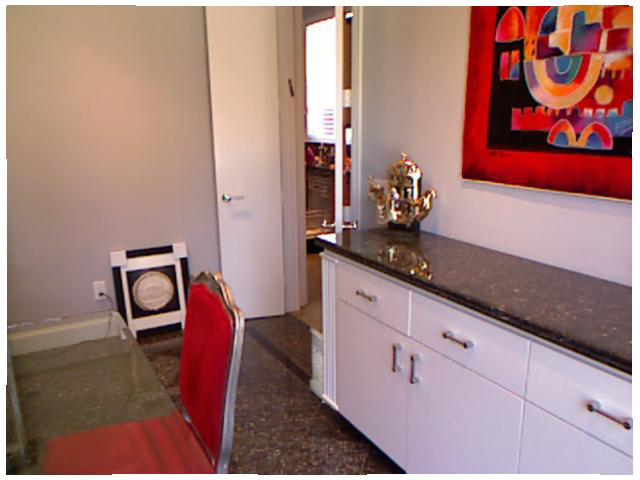

In [ ]:
transformed_training[6]['image']

In [ ]:
useful.normalize_depth(np.array(transformed_training[6]['depth']))

array([[12.98701299, 12.98701299, 12.98701299, ..., 21.73913043,
        21.73913043, 21.73913043],
       [12.98701299, 12.98701299, 12.98701299, ..., 21.73913043,
        21.73913043, 21.73913043],
       [12.98701299, 12.98701299, 12.98701299, ..., 21.73913043,
        21.73913043, 21.73913043],
       ...,
       [20.83333333, 20.83333333, 20.83333333, ..., 27.77777778,
        27.77777778, 27.77777778],
       [20.83333333, 20.83333333, 20.83333333, ..., 27.77777778,
        27.77777778, 27.77777778],
       [20.83333333, 20.83333333, 20.83333333, ..., 27.77777778,
        27.77777778, 27.77777778]])

In [ ]:
from PIL import Image
dictt = torch.load('/content/gdrive/MyDrive/Diploma/checkpoint_Regnet.pth')
model.load_state_dict(dictt['model_state_dict'] )
model.eval()
image = Image.open(f'/content/gdrive/MyDrive/Diploma/test.jpg')
result = my_predict(model, image, minDepth=10, maxDepth=10000)
result = result.reshape(480, 640)

(640, 480)
(480, 640, 3, 1)
torch.Size([1, 3, 480, 640])


In [ ]:
result = result.shape

In [ ]:
result*

array([[2.431626 , 2.431626 , 2.431626 , ..., 2.431626 , 2.431626 ,
        2.431626 ],
       [2.431626 , 2.431626 , 2.431626 , ..., 2.431626 , 2.431626 ,
        2.431626 ],
       [2.431626 , 2.431626 , 2.431626 , ..., 2.431626 , 2.431626 ,
        2.431626 ],
       ...,
       [2.431626 , 2.431626 , 2.431626 , ..., 2.381589 , 2.233541 ,
        2.431626 ],
       [2.431626 , 2.421278 , 2.4190576, ..., 2.3412359, 2.2240095,
        2.431626 ],
       [2.431626 , 2.4199667, 2.432051 , ..., 2.3191407, 2.2492113,
        2.431626 ]], dtype=float32)

In [ ]:
np.array(transformed_training[0]['depth'])/255*1000

array([[117.64705882, 117.64705882, 117.64705882, ...,  94.11764706,
         94.11764706,  94.11764706],
       [117.64705882, 117.64705882, 117.64705882, ...,  94.11764706,
         94.11764706,  94.11764706],
       [117.64705882, 117.64705882, 117.64705882, ...,  94.11764706,
         94.11764706,  94.11764706],
       ...,
       [ 82.35294118,  82.35294118,  82.35294118, ..., 105.88235294,
        105.88235294, 105.88235294],
       [ 82.35294118,  82.35294118,  82.35294118, ..., 105.88235294,
        105.88235294, 105.88235294],
       [ 82.35294118,  82.35294118,  82.35294118, ..., 105.88235294,
        105.88235294, 105.88235294]])

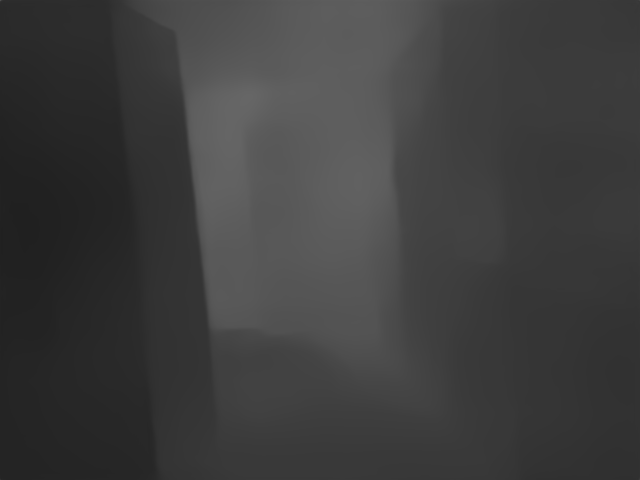

In [ ]:
Image.fromarray((result*255).astype(np.uint8))

#Sandbox

In [ ]:
from zipfile import ZipFile
from io import BytesIO

In [ ]:
from sklearn.metrics import mean_squared_error
import math
y_actual = [1,2,3,4,5]
y_predicted = [1.6,2.5,2.9,3,4.1]
MSE = mean_squared_error(y_actual, y_predicted)
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)

Root Mean Square Error:

0.6971370023173351


In [ ]:
def compute_errors(gt, pred):
  thresh = np.maximum((gt / pred), (pred / gt))
  a1 = (thresh < 1.25   ).mean()
  a2 = (thresh < 1.25 ** 2).mean()
  a3 = (thresh < 1.25 ** 3).mean()
  abs_rel = np.mean(np.abs(gt - pred) / gt)
  rmse = (gt - pred) ** 2
  rmse = np.sqrt(rmse.mean())
  log_10 = (np.abs(np.log10(gt)-np.log10(pred))).mean()
  return a1, a2, a3, abs_rel, rmse, log_10


In [ ]:
def load_test_data():    
    print('Loading test data...', end='')
    def extract_zip(input_zip):
        input_zip=ZipFile(input_zip)
        return {name: input_zip.read(name) for name in input_zip.namelist()}
    data = extract_zip('nyu_test.zip')
    
    rgb = np.load(BytesIO(data['eigen_test_rgb.npy']))
    depth = np.load(BytesIO(data['eigen_test_depth.npy']))
    crop = np.load(BytesIO(data['eigen_test_crop.npy']))
    print('Test data loaded.\n')
    
    return rgb, depth, crop

In [ ]:
rgb, depth, crop = load_test_data()

Loading test data...Test data loaded.



In [ ]:
rgb[0].shape

(480, 640, 3)

In [ ]:
model = smp.Unet(encoder_name="timm-regnety_004", 
                encoder_weights="imagenet",     
                in_channels=3,                  
                classes=1
                )
model.cuda()

In [ ]:
batch_size = 4
epochs = 4
optimizer = torch.optim.Adam( model.parameters(), 0.0001)
l1_criterion = nn.L1Loss()

In [ ]:
transformed_dataset_train = DepthDataset(data, nyu2_train,transform=transforms.Compose([
                                               RandomHorizontalFlip(),
                                               ToTensorTrain()
                                                           ]))
train_loader = DataLoader(transformed_dataset_train, batch_size, shuffle=True)

In [ ]:
PATH = f'/content/gdrive/MyDrive/Diploma/checkpoint_Regnet.pth'
losses = []

In [ ]:
for epoch in range(epochs):
  model.train()
  print('Epoch:', epoch)
  for i, sample_batched in enumerate(train_loader):
    optimizer.zero_grad()

    image = torch.autograd.Variable(sample_batched['image'].cuda())
    depth = torch.autograd.Variable(sample_batched['depth'].cuda(non_blocking=True))

    depth_n = useful.normalize_depth(depth)

    output = model(image)

    loss_l1 = l1_criterion(output, depth_n)
    loss_ssim = torch.clamp((1 - ssim(output, depth_n, val_range = 1000.0 / 10.0)) * 0.5, 0, 1)
    loss_edges = edges_loss(output, depth_n)

    loss_depth = loss_ssim + loss_edges + loss_l1*0.1

    
    loss_depth.backward()
    optimizer.step()
    losses.append(loss_depth.item())
    if i % 500 == 0:
      print('Loss: {loss_depth:.4f}'.format(loss_depth = loss_depth.item()))
  torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_depth,
            'losses': losses,
            }, PATH)
  print('checkpoint saved')
  

Epoch: 0
Loss: 1.4654
Loss: 0.3150
Loss: 0.1446
Loss: 0.1300
Loss: 0.1425
Loss: 0.1010
Loss: 0.1230
Loss: 0.1238
Loss: 0.1429
Loss: 0.1876
Loss: 0.1268
Loss: 0.1534
Loss: 0.1268
Loss: 0.0935
Loss: 0.1069
Loss: 0.1316
Loss: 0.1606
Loss: 0.1067
Loss: 0.0846
Loss: 0.1239
Loss: 0.1047
Loss: 0.0875
Loss: 0.1340
Loss: 0.0955
Loss: 0.1299
Loss: 0.1170
checkpoint saved
Epoch: 1
Loss: 0.1193
Loss: 0.0988
Loss: 0.1136
Loss: 0.1218
Loss: 0.0987
Loss: 0.0883
Loss: 0.1058
Loss: 0.0791
Loss: 0.1004
Loss: 0.1263
Loss: 0.0802
Loss: 0.0918
Loss: 0.0808
Loss: 0.0825
Loss: 0.1195
Loss: 0.0852
Loss: 0.1849
Loss: 0.1067
Loss: 0.0923
Loss: 0.1048
Loss: 0.1203
Loss: 0.0996
Loss: 0.1730
Loss: 0.0928
Loss: 0.1173
Loss: 0.0827
checkpoint saved
Epoch: 2
Loss: 0.0992
Loss: 0.0820
Loss: 0.0690
Loss: 0.0905
Loss: 0.0852
Loss: 0.1188
Loss: 0.0903
Loss: 0.1096
Loss: 0.0690
Loss: 0.0788
Loss: 0.0814
Loss: 0.1162
Loss: 0.0818
Loss: 0.0715
Loss: 0.0839
Loss: 0.1032
Loss: 0.0805
Loss: 0.0880
Loss: 0.0711
Loss: 0.0636
Los